In [1]:
# !pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 13.7 MB/s 
     |████████████████████████████████| 12.8 MB 34.2 MB/s 
     |████████████████████████████████| 240 kB 45.2 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 106 kB 52.1 MB/s 
     |████████████████████████████████| 37.5 MB 5.2 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 929 kB 66.0 MB/s 
     |████████████████████████████████| 50 kB 4.6 MB/s 
     |████████████████████████████████| 4.0 MB 52.0 MB/s 
     |████████████████████████████████| 1.9 MB 38.5 MB/s 
     |████████████████████████████████| 112 kB 49.6 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.4-py3-none-any.whl size=12274 sha256=11e093483d4c87f82e6b8ba9ffa8e4f939eb2fce5f22315db0d9b9a669371aee
  Stored in directory: /root/.cache/pip/wheels/40/2c/d7/aa0

# Fully Connected Graph with Randomized weight

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


def draw_graph(G, col, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=col, node_size=600,
                     alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


n = 6  # number of nodes in graph

np.random.seed(150)
edge_weights = np.random.randint(1, 5, size=(n, n))
edge_weights = edge_weights * edge_weights.T / 2

G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
for i in range(n):
    for j in range(n):
        if i > j:
            G.add_edge(i, j, weight=edge_weights[i, j])

colors = ['g' for node in G.nodes()]
pos = nx.spring_layout(G)

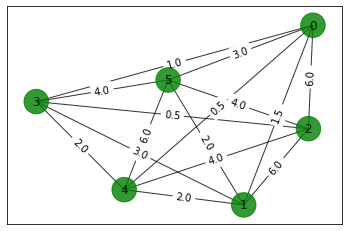

In [2]:
draw_graph(G, colors, pos)

In [3]:
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp['weight']

## Brute Force Algorithms to Calculate Optimal Solution

In [4]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x) + ' cost = ' + str(cost) + ' try = ' + str(b+1))

colors_brute = ['g' if xbest_brute[i] == 0 else 'c' for i in range(n)]
print('\nBestsolution = ' + str(xbest_brute) +
      ' cost = ' + str(best_cost_brute))

case = [0, 0, 0, 0, 0, 0] cost = 0.0 try = 1
case = [1, 0, 0, 0, 0, 0] cost = 12.0 try = 2
case = [0, 1, 0, 0, 0, 0] cost = 14.5 try = 3
case = [1, 1, 0, 0, 0, 0] cost = 23.5 try = 4
case = [0, 0, 1, 0, 0, 0] cost = 20.5 try = 5
case = [1, 0, 1, 0, 0, 0] cost = 20.5 try = 6
case = [0, 1, 1, 0, 0, 0] cost = 23.0 try = 7
case = [1, 1, 1, 0, 0, 0] cost = 20.0 try = 8
case = [0, 0, 0, 1, 0, 0] cost = 10.5 try = 9
case = [1, 0, 0, 1, 0, 0] cost = 20.5 try = 10
case = [0, 1, 0, 1, 0, 0] cost = 19.0 try = 11
case = [1, 1, 0, 1, 0, 0] cost = 26.0 try = 12
case = [0, 0, 1, 1, 0, 0] cost = 30.0 try = 13
case = [1, 0, 1, 1, 0, 0] cost = 28.0 try = 14
case = [0, 1, 1, 1, 0, 0] cost = 26.5 try = 15
case = [1, 1, 1, 1, 0, 0] cost = 21.5 try = 16
case = [0, 0, 0, 0, 1, 0] cost = 14.5 try = 17
case = [1, 0, 0, 0, 1, 0] cost = 25.5 try = 18
case = [0, 1, 0, 0, 1, 0] cost = 25.0 try = 19
case = [1, 1, 0, 0, 1, 0] cost = 33.0 try = 20
case = [0, 0, 1, 0, 1, 0] cost = 27.0 try = 21
case = [1, 0, 1, 0, 1, 

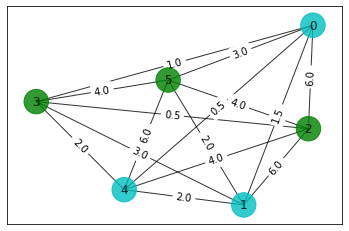

In [5]:
draw_graph(G, colors_brute, pos)

## QAOA

In [6]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter


def maxcut_obj(solution, graph):
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1 * w[i][j]
    return obj  # cost function(hamiltonian)


def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count  # sum_count is shot
    return avg/sum_count  # minimize this function


def create_qaoa_circ(graph, theta):
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index] * w[pair[0]]
                   [pair[1]], pair[0], pair[1])
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc


def get_expectation(graph, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [7]:
from scipy.optimize import minimize
expectation = get_expectation(G)
p = 1  # 32 64
res = minimize(expectation, np.ones(p*2)*np.pi/2,
               method='COBYLA', options={'maxiter': 2500})

In [8]:
res

     fun: -24.17529296875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([2.57910398, 1.5991255 ])

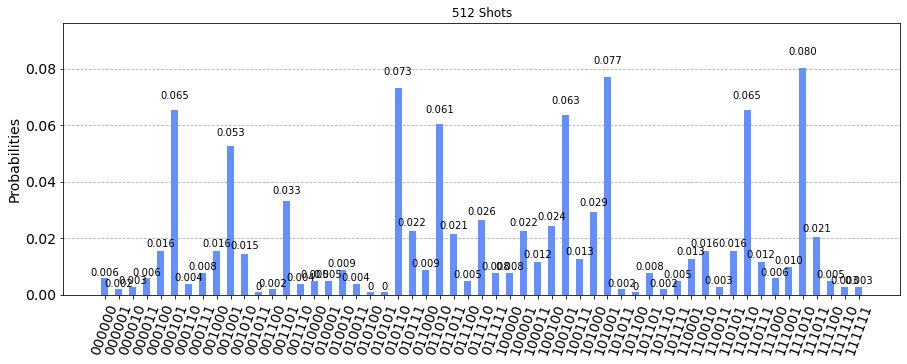

In [9]:
from qiskit.visualization import plot_histogram
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts, figsize=(15, 5), title='512 Shots')

In [10]:
result_col = list(max(counts, key=counts.get))
result_colors = ['g' if result_col[i] == '0' else 'c' for i in range(n)]

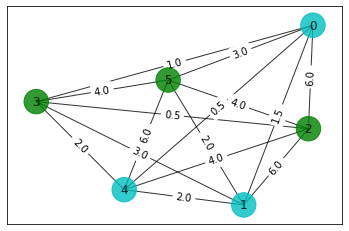

In [11]:
draw_graph(G, colors_brute, pos)

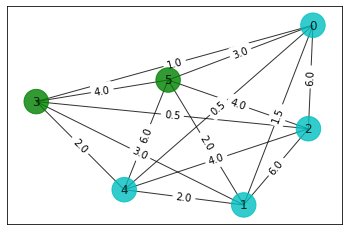

In [12]:
draw_graph(G, result_colors, pos)

In [13]:
print('xbest_brute =', xbest_brute)
result_col = list(map(int, result_col))
print('QAOA =', result_col)

xbest_brute = [1, 1, 0, 0, 1, 0]
QAOA = [1, 1, 1, 0, 1, 0]


# QAOA for Iris Dataset

In [14]:
from sklearn import datasets
iris = datasets.load_iris()
data = iris.data[:100, :2]  # :100 -> class 0,1
label = iris.target[:100]  # :100 -> class 0,1
# print(data)

In [15]:
import math


def dist(a, b):
    d = math.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
    d = round(d, 4)
    return d

In [28]:
import random

m = 6  # number of nodes
ranlist = [random.randint(0, 100) for r in range(m)]
print(ranlist)

datapoints = [data[i].tolist() for i in ranlist]
print(datapoints)
labels = [label[i] for i in ranlist]
print(labels)

H = nx.Graph()
H.add_nodes_from(np.arange(0, m, 1))
for i in range(m):
    for j in range(m):
        if i > j:
            H.add_edge(i, j, weight=dist(datapoints[i], datapoints[j]))

colors = ['g' for node in H.nodes()]
pos = nx.spring_layout(H)

[86, 55, 57, 3, 17, 67]
[[6.7, 3.1], [5.7, 2.8], [4.9, 2.4], [4.6, 3.1], [5.1, 3.5], [5.8, 2.7]]
[1, 1, 1, 0, 0, 1]


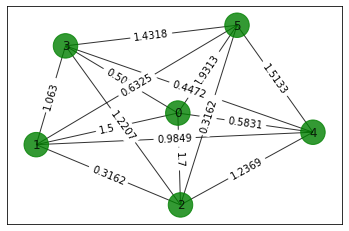

In [17]:
draw_graph(H, colors, pos)

In [18]:
w = np.zeros([m, m])
for i in range(m):
    for j in range(m):
        temp = H.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp['weight']

## Brute Force

In [19]:
best_cost_brute = 0
for b in range(2**m):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(m)))]
    cost = 0
    for i in range(m):
        for j in range(m):
            cost = cost + w[i, j] * x[i] * (1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x) + ' cost = ' + str(cost) + ' try = ' + str(b+1))

colors_brute = ['g' if xbest_brute[i] == 0 else 'c' for i in range(m)]
print('\nBestsolution = ' + str(xbest_brute) +
      ' cost = ' + str(best_cost_brute))

case = [0, 0, 0, 0, 0, 0] cost = 0.0 try = 1
case = [1, 0, 0, 0, 0, 0] cost = 6.2243 try = 2
case = [0, 1, 0, 0, 0, 0] cost = 4.4966 try = 3
case = [1, 1, 0, 0, 0, 0] cost = 7.7209 try = 4
case = [0, 0, 1, 0, 0, 0] cost = 4.79 try = 5
case = [1, 0, 1, 0, 0, 0] cost = 7.614300000000001 try = 6
case = [0, 1, 1, 0, 0, 0] cost = 8.6542 try = 7
case = [1, 1, 1, 0, 0, 0] cost = 8.4785 try = 8
case = [0, 0, 0, 1, 0, 0] cost = 4.672599999999999 try = 9
case = [1, 0, 0, 1, 0, 0] cost = 9.877099999999999 try = 10
case = [0, 1, 0, 1, 0, 0] cost = 7.043199999999999 try = 11
case = [1, 1, 0, 1, 0, 0] cost = 9.2477 try = 12
case = [0, 0, 1, 1, 0, 0] cost = 7.021199999999999 try = 13
case = [1, 0, 1, 1, 0, 0] cost = 8.825700000000001 try = 14
case = [0, 1, 1, 1, 0, 0] cost = 8.7594 try = 15
case = [1, 1, 1, 1, 0, 0] cost = 7.5639 try = 16
case = [0, 0, 0, 0, 1, 0] cost = 4.7654 try = 17
case = [1, 0, 0, 0, 1, 0] cost = 9.8235 try = 18
case = [0, 1, 0, 0, 1, 0] cost = 7.292199999999999 try = 19
case =

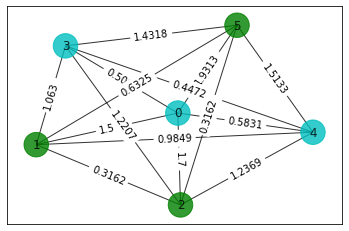

In [20]:
draw_graph(H, colors_brute, pos)

## QAOA

In [21]:
from scipy.optimize import minimize
expectation = get_expectation(H)
p = 1  # 32 64
res = minimize(expectation, np.ones(p*2)*np.pi/2,
               method='COBYLA', options={'maxiter': 2500})

In [22]:
res

     fun: -7.8231050781250016
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 35
  status: 1
 success: True
       x: array([2.53586112, 1.53243662])

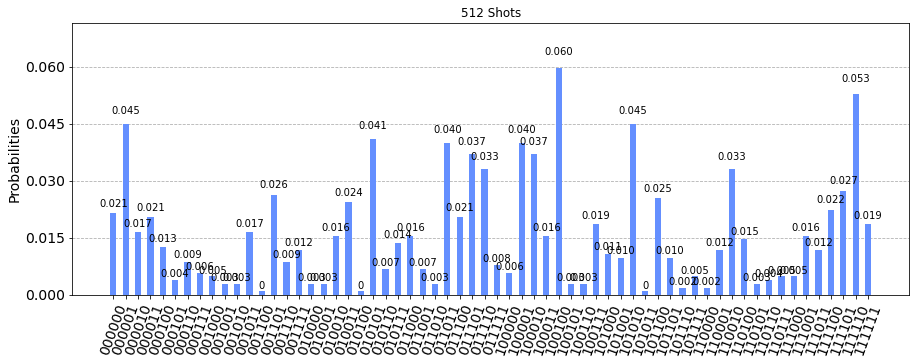

In [23]:
from qiskit.visualization import plot_histogram
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(H, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts, figsize=(15, 5), title='512 Shots')

In [24]:
result_col = list(max(counts, key=counts.get))
result_colors = ['g' if result_col[i] == '0' else 'c' for i in range(m)]

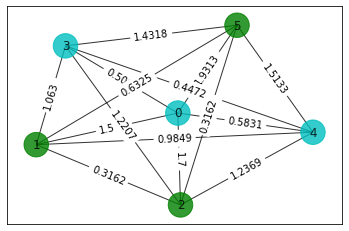

In [25]:
draw_graph(H, colors_brute, pos)

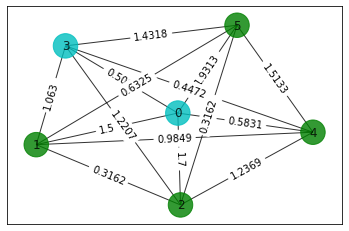

In [26]:
draw_graph(H, result_colors, pos)

In [27]:
print('xbest_brute =', xbest_brute)
result_col = list(map(int, result_col))
print('QAOA =', result_col)

xbest_brute = [1, 0, 0, 1, 1, 0]
QAOA = [1, 0, 0, 1, 0, 0]
